In [ ]:
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)

from zipfile import ZipFile
! cp '/content/drive/MyDrive/ML_Capstone/drive-download.zip' '/content'
from zipfile import ZipFile
zip = ZipFile('/content/drive-download.zip')
zip.extractall()

Mounted at /content/drive/


In [ ]:
# importing required packages
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import numpy as np
import cv2
import pickle as pkl
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
import pandas as pd

# Dataset and Dataloaders

In [ ]:
# Set device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Lazy Loading

data
-train
  - X
    - 1
      - rgb
        - 0.png
        - 1.png
        - 2.png
      - depth.npy
      - field_id.pkl
    
    - 2

    - ...
  - Y
    - 1.npy
    - 2.npy

-test

In [ ]:
class LazyLoadDataset(Dataset):
  def __init__(self,path,train=True,transform=None):
    self.train = train
    self.transform = transform
    path = path + ("train/" if train else "test/")

    self.pathX = path + "X/"
    self.pathY = path + "Y/"

    self.data = os.listdir(self.pathX)

  def __getitem__(self,idx):
    f = self.data[idx]

    # X
    # read rgb images
    img0 = cv2.imread(self.pathX + f + "/rgb/0.png")/255
    #img0 = Image.open(self.pathX + f + "/rgb/0.png")

    if self.transform is not None:
      img0 = self.transform(img0)

    # read field ID
    field_id = pkl.load(open(self.pathX + f + "/field_id.pkl","rb"))

    if self.train==True:
      # Y 
      Y = np.load(self.pathY + f + ".npy")*1000
      return (img0[0].float().type(torch.float32),field_id),torch.from_numpy(Y).float().type(torch.float32)

    else: # if test, there is no Y
      return img0[0].float().type(torch.float32),field_id

  def __len__(self):
    return len(self.data)


#Normalization: Compute Mean and Std

In [ ]:
train_dataset_raw = LazyLoadDataset("/content/",train=True,transform=ToTensor()) 
means=[]
stds=[]
for i in range(3396):
  (img_i, id_i),Y_i=train_dataset_raw[i]
  means.append([torch.mean(img_i).item()])
  stds.append([torch.std(img_i).item()])

In [ ]:
img_i.shape

torch.Size([224, 224])

In [ ]:
means

[[0.4062996804714203],
 [0.3942432105541229],
 [0.41102153062820435],
 [0.42132341861724854],
 [0.39916232228279114],
 [0.3890407383441925],
 [0.40521472692489624],
 [0.39096692204475403],
 [0.41952553391456604],
 [0.36131125688552856],
 [0.3902866840362549],
 [0.42958784103393555],
 [0.3632660210132599],
 [0.3879729211330414],
 [0.38613423705101013],
 [0.35617703199386597],
 [0.3733989894390106],
 [0.3703407049179077],
 [0.41431567072868347],
 [0.3966390788555145],
 [0.3912529945373535],
 [0.4013592004776001],
 [0.3832639455795288],
 [0.39186185598373413],
 [0.3848583698272705],
 [0.3673672080039978],
 [0.41414570808410645],
 [0.41368699073791504],
 [0.39543086290359497],
 [0.3926662802696228],
 [0.38681644201278687],
 [0.38366448879241943],
 [0.4003279507160187],
 [0.38668203353881836],
 [0.4114687442779541],
 [0.3776698708534241],
 [0.41793009638786316],
 [0.37580642104148865],
 [0.380941241979599],
 [0.41485902667045593],
 [0.4309454560279846],
 [0.3862280249595642],
 [0.3968631625

In [ ]:
norm_mean=np.mean(means,axis =0)
norm_mean = list(norm_mean)
norm_mean

[0.3959879955305368]

In [ ]:
norm_std=np.mean(stds,axis=0)
norm_std = list(norm_std)
norm_std

[0.21113784175510963]

#Train Dataset & Train loader

In [ ]:
#transform=transforms.Compose([transforms.ToTensor()])
train_dataset = LazyLoadDataset("/content/",transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(norm_mean, norm_std)]))

In [ ]:
(img0, field_id), Y = train_dataset[0]

In [ ]:
img0.shape

torch.Size([224, 224])

In [ ]:
batch_size_train = 4
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)

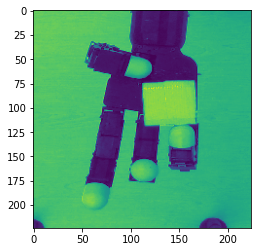

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
  plt.imshow(data[0][0])
  break
  

#Test Dataset & Test loader

In [ ]:
test_dataset = LazyLoadDataset("/content/",train=False,transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(norm_mean, norm_std),
                   ])) #,transform=transform

batch_size_test = 2
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=True)

# Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        
        # We use Sequential for simplicity
        self.stack = nn.Sequential(nn.Conv2d(input_channels, conv_feature,kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.Conv2d(conv_feature, conv_feature,kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   
                                   nn.Flatten(),
                                   nn.Linear(conv_feature*53*53, fc_feature),
                                   nn.ReLU(),
                                   nn.Linear(fc_feature, output_size)
        )
                 
                                   
                                  
    def forward(self, x):
        x = self.stack(x)
        return x

In [ ]:
# Model input/output settings
input_channels = 1
conv_feature = 6 
fc_feature = 50
output_size=12

In [ ]:
def train(epoch, model, optimizer,loader=train_loader):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        loader: val/train loader
    """
    model.train()
    for batch_idx,((data, id),target) in enumerate(loader):
        # send to device
        data, target = data.to(device), target.to(device)
        data = data.view(len(id),1,224, 224)

        # consider passing different data augmentation in training
        # data = F.invert()
        # data = F.adjust_sharpness(data,sharpness_factor = 0.5)
        # data = F.adjust_hue(data,hue_factor = 0.9)
        # data = F.adjust_saturation(data,saturation_factor = 0.5)

        # make sure we erase all the gradients before computing new ones
        optimizer.zero_grad() 
        
        # forward propagation
        output = model(data)
        #print(output.dtype)

        #RMSE loss
        loss = torch.sqrt(nn.functional.mse_loss(output,target))
        
        # backward propagation
        loss.backward()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss))
            

In [ ]:
def test(model):
    """
    Test the model

    Args:
        model (nn.Module): model to test
      
    """
    model.eval()
    ids = []
    preds = []
    with torch.no_grad():
      for batch_idx,(data, id) in enumerate(test_loader):
        # send to device
        data = data.view(len(id),1,224, 224)
        data = data.to(device)          
        pred = model(data)
        for i in range(len(id)):
          ids.append(id[i])
          preds.append(np.array(pred[i].cpu()/1000,dtype="float64"))

    return ids, preds  
    

In [ ]:
def get_n_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Cross-Validation & Grid-Search for determining hyperparameters

What should hyperparameters in the models be? We could perform grid-search on the whole train dataset and pick the best-performing hyerparameters. But to avoid over-fitting on the train dataset, we split the whole train dataset into 9:1.




*   cross_val_train_set (90% of train dataset)
*   cross_val_test_set (10% of train dataset)


We train our model on the cross_val_train_set and test our model on cross_val_test_set. We pick the best-performing hyperparameters on the cross_val_test_set.

After all these steps, we train our model using the picked hyperparameters on the whole train dataset.

In [ ]:
cross_val_train_set, cross_val_test_set = train_test_split(train_dataset, test_size=0.1)

In [ ]:
# Sanity Check
len(cross_val_train_set) == int(len(train_dataset)*0.9)
len(cross_val_train_set)

3056

In [ ]:
batch_size_cross_val_train = 4
batch_size_cross_val_test = len(cross_val_test_set) # = 340
len(cross_val_test_set)

340

In [ ]:
cross_val_train_loader=DataLoader(cross_val_train_set,batch_size=batch_size_cross_val_train,shuffle=True)
cross_val_test_loader=DataLoader(cross_val_test_set,batch_size=batch_size_cross_val_test,shuffle=True)

In [ ]:
len(cross_val_test_loader)

1

In [ ]:
def cross_val(model):
    """
    Test the model

    Args:
        model (nn.Module): model to test
      
    """
    model.eval()
    # We can just edit on the code for train(). We should delete the bakward propagation part and optimizer part.

    with torch.no_grad():
      for batch_idx,((data, id),target) in enumerate(cross_val_test_loader):
          # send to device
          data = data.view(len(id),1,224, 224)
    
          if batch_idx==0:
            data, target = data.to(device), target.to(device)
            
            # forward propagation
            output = model(data)

            #RMSE loss
            loss = torch.sqrt(nn.functional.mse_loss(output,target)) 
            return loss.item()

In [ ]:
def SGD_hyper_tuning(lr_list,momentum_list):  
  for j in momentum_list:
    for i in lr_list:
      model_cnn = CNN(input_channels, conv_feature, fc_feature, output_size) # create CNN model
      model_cnn.to(device)
      print("lr=",i,"momentum=",j)
      train(epoch=0, model=model_cnn, optimizer=torch.optim.SGD(model_cnn.parameters(), lr=i,momentum=j),loader=cross_val_train_loader)
      print("Validation Performance:",cross_val(model_cnn))

In [ ]:
lr_list = [1e-5,1e-4,1e-3,1e-2,1e-1]
momentum_list = [0.99,0.97,0.95,0.93,0.91]
SGD_hyper_tuning(lr_list,momentum_list)

lr= 1e-05 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 64.290878
Train Epoch: 0 [800/3056 (26%)]	Loss: 61.931644
Train Epoch: 0 [1600/3056 (52%)]	Loss: 26.486588
Train Epoch: 0 [2400/3056 (79%)]	Loss: 17.456388
Validation Performance: 13.425628662109375
lr= 0.0001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 63.132484
Train Epoch: 0 [800/3056 (26%)]	Loss: 29.071518
Train Epoch: 0 [1600/3056 (52%)]	Loss: 17.724449
Train Epoch: 0 [2400/3056 (79%)]	Loss: 13.414598
Validation Performance: 11.718585014343262
lr= 0.001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 70.126877
Train Epoch: 0 [800/3056 (26%)]	Loss: 30.548777
Train Epoch: 0 [1600/3056 (52%)]	Loss: 15.257091
Train Epoch: 0 [2400/3056 (79%)]	Loss: 19.301151
Validation Performance: 13.354385375976562
lr= 0.01 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 69.040855
Train Epoch: 0 [800/3056 (26%)]	Loss: 27.096169
Train Epoch: 0 [1600/3056 (52%)]	Loss: 24.623741
Train Epoch: 0 [2400/3056 (79%)]	Loss: 21.747398
Validat

Top 3 Performance hyperparameters (Results may vary if rerun the program)

1.  lr = 1e-3, momentum = 0.95
2.  lr = 1e-3, momentum = 0.91
3.  lr = 1e-4, momentum = 0.91


In [ ]:
lr_list = [8e-4,9e-4,1e-3,2e-3,3e-3]
momentum_list = [0.99,0.97,0.95,0.93,0.91]
SGD_hyper_tuning(lr_list,momentum_list)

lr= 0.0008 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 64.671677
Train Epoch: 0 [800/3056 (26%)]	Loss: 27.706041
Train Epoch: 0 [1600/3056 (52%)]	Loss: 14.228812
Train Epoch: 0 [2400/3056 (79%)]	Loss: 12.774019
Validation Performance: 12.225136756896973
lr= 0.0009 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 65.710083
Train Epoch: 0 [800/3056 (26%)]	Loss: 49.431416
Train Epoch: 0 [1600/3056 (52%)]	Loss: 22.301029
Train Epoch: 0 [2400/3056 (79%)]	Loss: 17.449097
Validation Performance: 22.69520378112793
lr= 0.001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 63.891830
Train Epoch: 0 [800/3056 (26%)]	Loss: 43.684605
Train Epoch: 0 [1600/3056 (52%)]	Loss: 28.728874
Train Epoch: 0 [2400/3056 (79%)]	Loss: 14.607389
Validation Performance: 15.762203216552734
lr= 0.002 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 64.259529
Train Epoch: 0 [800/3056 (26%)]	Loss: 66.072922
Train Epoch: 0 [1600/3056 (52%)]	Loss: 34.223793
Train Epoch: 0 [2400/3056 (79%)]	Loss: 21.948195
Valida

Top 1 Performance

5.   lr = 1e-3, momentum = 0.95

# lr=1e-3, momentum=0.95, 20 epoch, train_batch_size = 4, no lr decay

In [ ]:
model_cnn = CNN(input_channels, conv_feature, fc_feature, output_size) # create Cnn model
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-3,momentum=0.95) 

print("lr=",1e-3,"momentum=",0.95)
for epoch in range(20):
  train(epoch, model=model_cnn, optimizer=torch.optim.SGD(model_cnn.parameters(), lr=1e-3,momentum=0.95),loader=train_loader)


In [ ]:
torch.save(model_cnn,'/content/drive/MyDrive/ML_Capstone/project_v3_CNN_AUGimg0_0001095_nodecay_20ep.pt')
model_cnn = torch.load('/content/drive/MyDrive/ML_Capstone/project_v3_CNN_AUGimg0_0001095_nodecay_20ep.pt')
model_cnn.eval()

ids,preds = test(model_cnn)

outfile = '/content/drive/MyDrive/ML_Capstone/submission_v3_AUGimg0_0001095_nodecay_20ep.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']

df = pd.concat([pd.DataFrame(ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))